# Build QFT

In [99]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info.operators import Operator


def controlled_rotation_gate(k):
    rotation = np.array(
        [[1, 0], [0, np.exp(2 * np.pi * 1j / 2**k)]], dtype=np.complex128
    )
    rotation_gate = Operator(rotation)
    circuit = QuantumCircuit(1)
    circuit.append(rotation_gate, [0])
    rotation_gate = circuit.to_gate(label="R{}".format(k))
    controlled_rotation = rotation_gate.control(1)
    return controlled_rotation

def swap_all(n):
    """Creates a circuit that swaps all qubits"""
    circuit = QuantumCircuit(n, name='SWAP_ALL')
    for i in range(n//2):
        circuit.swap(i, n-i-1)
    return circuit

def qft_gate(n, swap=False):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n, name='QFT')
    for i in range(n):
        circuit.h(i)
        for j in range(i+1, n):
            circuit.append(controlled_rotation_gate(j-i+1), [j, i])
    if swap:
        circuit.append(swap_all(n), range(n))
    return circuit

n_qubits = 1

qft_circuit = QuantumCircuit(n_qubits+1, name='QFT')

for i in range(qft_circuit.num_qubits):
    qft_circuit.h(i)
    for j in range(i+1, qft_circuit.num_qubits):
        qft_circuit.append(controlled_rotation_gate(j-i+1), [j, i])
    # qft_circuit.barrier()

qft = qft_circuit.to_gate(label='QFT')
inverse_qft_gate = qft.inverse()
qft_circuit.draw()

┌───┐┌────┐     
q_0: ┤ H ├┤ R2 ├─────
     └───┘└─┬──┘┌───┐
q_1: ───────■───┤ H ├
                └───┘

# Test Draper QFT Adder

In [2]:
from qiskit.circuit.library import DraperQFTAdder
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

n_qubits = 3

first_register = QuantumRegister(n_qubits, name='first')
second_register = QuantumRegister(n_qubits, name='second')
first_classical = ClassicalRegister(n_qubits, name='first_classical')
second_classical = ClassicalRegister(n_qubits, name='second_classical')
carry_register = QuantumRegister(1, name='carry')
circuit = QuantumCircuit(first_register, second_register,  carry_register, first_classical, second_classical)
adder = DraperQFTAdder(n_qubits, kind="half")
print(adder.num_qubits)
circuit.x(first_register[0])
circuit.x(second_register[0])

circuit.append(adder, first_register[:] + second_register[:] + [carry_register[0]])
circuit.measure(first_register, first_classical)
circuit.measure(second_register, second_classical)
circuit.decompose(reps=1).draw()


7


┌───────────┐┌─────────────────┐┌─┐               
           first_0: ┤ U3(π,0,π) ├┤0                ├┤M├───────────────
                    └───────────┘│                 │└╥┘┌─┐            
           first_1: ─────────────┤1                ├─╫─┤M├────────────
                                 │                 │ ║ └╥┘┌─┐         
           first_2: ─────────────┤2                ├─╫──╫─┤M├─────────
                    ┌───────────┐│                 │ ║  ║ └╥┘┌─┐      
          second_0: ┤ U3(π,0,π) ├┤3 DraperQFTAdder ├─╫──╫──╫─┤M├──────
                    └───────────┘│                 │ ║  ║  ║ └╥┘┌─┐   
          second_1: ─────────────┤4                ├─╫──╫──╫──╫─┤M├───
                                 │                 │ ║  ║  ║  ║ └╥┘┌─┐
          second_2: ─────────────┤5                ├─╫──╫──╫──╫──╫─┤M├
                                 │                 │ ║  ║  ║  ║  ║ └╥┘
             carry: ─────────────┤6                ├─╫──╫──╫──╫──╫──╫─
                                 └─────────────────┘ ║  ║  ║  ║  ║  ║ 
 first_classical: 3/═════════════════════════════════╩══╩══╩══╬══╬══╬═
                                                     0  1  2  ║  ║  ║ 
second_classical: 3/══════════════════════════════════════════╩══╩══╩═
                                                              0  1  2

In [3]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)

{'010 001': 1000}


In [5]:
def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])

def resultToNumber(counts: dict):
    results_dict = {}
    for keys, value in counts.items():
        splitted_measurements = keys.split(' ')
        # output = int(splitted_measurements[1], 2)
        first_number = int(splitted_measurements[1], 2)
        computed_output = int(splitted_measurements[0],2)
        results_dict[(first_number, computed_output)] = value
    return results_dict


for firstNumber in range(2**(n_qubits-1)):
    for secondNumber in range(2**(n_qubits-1)):
        circ = QuantumCircuit(carry_register, first_register, second_register, first_classical, second_classical)
        # load first number
        loadNumber(circ, first_register, firstNumber)
        # load second number
        loadNumber(circ, second_register, secondNumber)
        circ.barrier()
        circ.append(adder, first_register[:] + second_register[:] + [carry_register[0]])
        circ.barrier()
        circ.measure(first_register, first_classical)
        circ.measure(second_register, second_classical)

        job = execute(circ, Aer.get_backend('qasm_simulator'), shots=1000)
        counts = job.result().get_counts()
        processed_counts = resultToNumber(counts)
        print("{} + {} ".format(firstNumber, secondNumber), processed_counts)

0 + 0  {(0, 0): 1000}
0 + 1  {(0, 1): 1000}
0 + 2  {(0, 2): 1000}
0 + 3  {(0, 3): 1000}
1 + 0  {(1, 1): 1000}
1 + 1  {(1, 2): 1000}
1 + 2  {(1, 3): 1000}
1 + 3  {(1, 4): 1000}
2 + 0  {(2, 2): 1000}
2 + 1  {(2, 3): 1000}
2 + 2  {(2, 4): 1000}
2 + 3  {(2, 5): 1000}
3 + 0  {(3, 3): 1000}
3 + 1  {(3, 4): 1000}
3 + 2  {(3, 5): 1000}
3 + 3  {(3, 6): 1000}


# 2 qubit example

In [137]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import QFT

test_circuit = QuantumCircuit(2, 2)
test_circuit.append(QFT(2), reversed(range(2)))
test_circuit.cz(1, 0)
test_circuit.append(QFT(2).inverse(), reversed(range(2)))
test_circuit.measure(range(2), range(2))
test_circuit.draw()

┌──────┐   ┌───────┐┌─┐   
q_0: ┤1     ├─■─┤1      ├┤M├───
     │  QFT │ │ │  IQFT │└╥┘┌─┐
q_1: ┤0     ├─■─┤0      ├─╫─┤M├
     └──────┘   └───────┘ ║ └╥┘
c: 2/═════════════════════╩══╩═
                          0  1

In [138]:
backend = Aer.get_backend('qasm_simulator')
job = execute(test_circuit, backend, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)

{'01': 258, '00': 236, '11': 271, '10': 235}


# Build NMAdd

In [226]:

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info.operators import Operator

def rotation(k):
    return np.array([[1, 0], [0, np.exp(2 * np.pi * 1j / 2**k)]])


def controlled_rotation_gate(k):
    inverse_rotation = np.array(
        [[1, 0], [0, np.exp(2 * np.pi * 1j / 2**k)]], dtype=np.complex128
    )
    inverse_rotation_gate = Operator(inverse_rotation)
    circuit = QuantumCircuit(1)
    circuit.append(inverse_rotation_gate, [0])
    inverse_rotation_gate = circuit.to_gate(label="R{}".format(k))
    controlled_rotation = inverse_rotation_gate.control(1)
    return controlled_rotation


def build_NMAdd(first_num_len, second_num_len):
    first_number_register = QuantumRegister(first_num_len + 1, name="phi(a)")
    second_number_register = QuantumRegister(second_num_len, name="b")
    quantum_circuit = QuantumCircuit(first_number_register, second_number_register, name="NMAdd")
    counter = 1
    for i in reversed(range(1, first_num_len + 1)):
        for j in reversed(range(counter)):
            quantum_circuit.append(
                controlled_rotation_gate(counter - j),
                [second_number_register[second_num_len - j - 1]] + [first_number_register[i]],
            )
        if counter < second_num_len:
            counter += 1
    for j in reversed(range(counter)):
        quantum_circuit.append(
            controlled_rotation_gate(counter - j + 1),
            [second_number_register[second_num_len - j - 1]] + [first_number_register[0]],
        )
    
    return quantum_circuit

first_len = 3
second_len = 3

first_register = QuantumRegister(first_len+1, name="phi(a)")
second_register = QuantumRegister(second_len, name="b")


test_circuit = QuantumCircuit(first_register, second_register)

test_circuit.append(build_NMAdd(first_len, second_len), range(first_len+second_len+1))
test_circuit.draw()

┌────────┐
phi(a)_0: ┤0       ├
          │        │
phi(a)_1: ┤1       ├
          │        │
phi(a)_2: ┤2       ├
          │        │
phi(a)_3: ┤3 NMAdd ├
          │        │
     b_0: ┤4       ├
          │        │
     b_1: ┤5       ├
          │        │
     b_2: ┤6       ├
          └────────┘

# Build MAdd

In [217]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info.operators import Operator

def rotation(k):
    return np.array([[1, 0], [0, np.exp(2 * np.pi * 1j / 2**k)]])


def controlled_rotation_gate(k):
    inverse_rotation = np.array(
        [[1, 0], [0, np.exp(2 * np.pi * 1j / 2**k)]], dtype=np.complex128
    )
    inverse_rotation_gate = Operator(inverse_rotation)
    circuit = QuantumCircuit(1)
    circuit.append(inverse_rotation_gate, [0])
    inverse_rotation_gate = circuit.to_gate(label="R{}".format(k))
    controlled_rotation = inverse_rotation_gate.control(1)
    return controlled_rotation


def build_MAdd(m, n):
    first_number_register = QuantumRegister(n + 1, name="phi(a)")
    second_number_register = QuantumRegister(m, name="b")
    quantum_circuit = QuantumCircuit(first_number_register, second_number_register, name="MAdd")
    counter = 1
    for i in reversed(range(0, n + 1)):
        for j in reversed(range(counter)):
            quantum_circuit.append(
                controlled_rotation_gate(counter - j),
                [second_number_register[m - j - 1]] + [first_number_register[i]],
            )
        if counter < m:
            counter += 1
        # quantum_circuit.barrier()
    return quantum_circuit

first_register = QuantumRegister(3, name="phi(a)")
second_register = QuantumRegister(2, name="b")


test_circuit = QuantumCircuit(first_register, second_register)

test_circuit.append(build_MAdd(2, 2), range(5))
test_circuit.decompose().draw()

┌────┐      ┌────┐
phi(a)_0: ────────────┤ R1 ├──────┤ R2 ├
          ┌────┐      └─┬──┘┌────┐└─┬──┘
phi(a)_1: ┤ R1 ├────────┼───┤ R2 ├──┼───
          └─┬──┘┌────┐  │   └─┬──┘  │   
phi(a)_2: ──┼───┤ R1 ├──┼─────┼─────┼───
            │   └─┬──┘  │     │     │   
     b_0: ──■─────┼─────■─────┼─────┼───
                  │           │     │   
     b_1: ────────■───────────■─────■───

# Build QNMAdd

In [219]:
def build_QNMAdd(first_num_length, second_num_length):
    carry_register = QuantumRegister(1, name="c")
    first_register = QuantumRegister(first_num_length, name="a")
    second_register = QuantumRegister(second_num_length, name="b")
    circ = QuantumCircuit(carry_register, first_register, second_register, name="QNMAdd")
    qft = qft_gate(first_num_length+1)
    inverse_qft = qft.inverse()
    circ.ccx(first_register[0], second_register[0], carry_register[0], ctrl_state="10")
    circ.ccx(first_register[0], second_register[0], carry_register[0], ctrl_state="01")
    circ.append(qft, [carry_register[0]]+ first_register[:])
    circ.barrier()
    circ.append(build_NMAdd(first_num_length, second_num_length), carry_register[:] + first_register[:] + second_register[:])
    circ.barrier()
    circ.append(inverse_qft, [carry_register[0]]+ first_register[:])
    return circ

carry_register = QuantumRegister(1, name="c")
first_register = QuantumRegister(2, name="a")
second_register = QuantumRegister(3, name="b")

test_circuit = QuantumCircuit(carry_register, first_register, second_register)


test_circuit.x(first_register[1])
test_circuit.x(second_register[0])

test_circuit.append(build_QNMAdd(2, 3), carry_register[:] + first_register[:] + second_register[:])
test_circuit.measure_all()
test_circuit.decompose().draw()
    

┌───┐┌───┐┌──────┐ ░ ┌────────┐ ░ ┌─────────┐ ░ ┌─┐      »
     c: ─────────────┤ X ├┤ X ├┤0     ├─░─┤0       ├─░─┤0        ├─░─┤M├──────»
                     └─┬─┘└─┬─┘│      │ ░ │        │ ░ │         │ ░ └╥┘┌─┐   »
   a_0: ───────────────o────■──┤1 QFT ├─░─┤1       ├─░─┤1 QFT_dg ├─░──╫─┤M├───»
        ┌───────────┐  │    │  │      │ ░ │        │ ░ │         │ ░  ║ └╥┘┌─┐»
   a_1: ┤ U3(π,0,π) ├──┼────┼──┤2     ├─░─┤2       ├─░─┤2        ├─░──╫──╫─┤M├»
        ├───────────┤  │    │  └──────┘ ░ │  NMAdd │ ░ └─────────┘ ░  ║  ║ └╥┘»
   b_0: ┤ U3(π,0,π) ├──■────o───────────░─┤3       ├─░─────────────░──╫──╫──╫─»
        └───────────┘                   ░ │        │ ░             ░  ║  ║  ║ »
   b_1: ────────────────────────────────░─┤4       ├─░─────────────░──╫──╫──╫─»
                                        ░ │        │ ░             ░  ║  ║  ║ »
   b_2: ────────────────────────────────░─┤5       ├─░─────────────░──╫──╫──╫─»
                                        ░ └────────┘ ░             ░  ║  ║  ║ »
meas: 6/══════════════════════════════════════════════════════════════╩══╩══╩═»
                                                                      0  1  2 »
«                 
«     c: ─────────
«                 
«   a_0: ─────────
«                 
«   a_1: ─────────
«        ┌─┐      
«   b_0: ┤M├──────
«        └╥┘┌─┐   
«   b_1: ─╫─┤M├───
«         ║ └╥┘┌─┐
«   b_2: ─╫──╫─┤M├
«         ║  ║ └╥┘
«meas: 6/═╩══╩══╩═
«         3  4  5

In [220]:

def build_QNMAdd(n, m):
    carry_register = QuantumRegister(1, name="c")
    first_register = QuantumRegister(n, name="a")
    second_register = QuantumRegister(m, name="b")
    circ = QuantumCircuit(first_register, second_register,  carry_register, name="QNMAdd")
    qft = qft_gate(n+1)
    inverse_qft = qft.inverse()
    circ.ccx(first_register[-1], second_register[-1], carry_register[0], ctrl_state="10")
    circ.ccx(first_register[-1], second_register[-1], carry_register[0], ctrl_state="01")
    circ.append(qft, reversed(second_register[:]+ [carry_register[0]]))
    circ.barrier()
    circ.append(build_NMAdd(m, n), reversed(first_register[:]  + second_register[:]+carry_register[:]))
    circ.barrier()
    circ.append(inverse_qft, reversed(second_register[:]+ [carry_register[0]]))
    return circ

bit_length = 3
carry_register = QuantumRegister(1, name="c")
first_register = QuantumRegister(bit_length, name="a")
second_register = QuantumRegister(bit_length, name="b")
first_register_results = ClassicalRegister(bit_length, name="a_results")
second_register_results = ClassicalRegister(bit_length+1, name="b_results")

test_circuit = QuantumCircuit(first_register, second_register,carry_register, first_register_results, second_register_results)


test_circuit.x(first_register[2])
test_circuit.x(second_register[0])

test_circuit.append(build_QNMAdd(bit_length, bit_length), first_register[:] + second_register[:]+ carry_register[:])
test_circuit.measure(first_register, first_register_results)
test_circuit.measure(second_register[:]+ carry_register[:], second_register_results)
test_circuit.decompose().draw()

░ ┌────────┐ ░            ┌─┐   »
        a_0: ────────────────────────────────░─┤6       ├─░────────────┤M├───»
                                             ░ │        │ ░            └╥┘┌─┐»
        a_1: ────────────────────────────────░─┤5       ├─░─────────────╫─┤M├»
             ┌───────────┐                   ░ │        │ ░             ║ └╥┘»
        a_2: ┤ U3(π,0,π) ├──o────■───────────░─┤4       ├─░─────────────╫──╫─»
             ├───────────┤  │    │  ┌──────┐ ░ │        │ ░ ┌─────────┐ ║  ║ »
        b_0: ┤ U3(π,0,π) ├──┼────┼──┤3     ├─░─┤3 NMAdd ├─░─┤3        ├─╫──╫─»
             └───────────┘  │    │  │      │ ░ │        │ ░ │         │ ║  ║ »
        b_1: ───────────────┼────┼──┤2     ├─░─┤2       ├─░─┤2        ├─╫──╫─»
                            │    │  │  QFT │ ░ │        │ ░ │  QFT_dg │ ║  ║ »
        b_2: ───────────────■────o──┤1     ├─░─┤1       ├─░─┤1        ├─╫──╫─»
                          ┌─┴─┐┌─┴─┐│      │ ░ │        │ ░ │         │ ║  ║ »
          c: ─────────────┤ X ├┤ X ├┤0     ├─░─┤0       ├─░─┤0        ├─╫──╫─»
                          └───┘└───┘└──────┘ ░ └────────┘ ░ └─────────┘ ║  ║ »
a_results: 3/═══════════════════════════════════════════════════════════╩══╩═»
                                                                        0  1 »
b_results: 4/════════════════════════════════════════════════════════════════»
                                                                             »
«                            
«        a_0: ───────────────
«                            
«        a_1: ───────────────
«             ┌─┐            
«        a_2: ┤M├────────────
«             └╥┘┌─┐         
«        b_0: ─╫─┤M├─────────
«              ║ └╥┘┌─┐      
«        b_1: ─╫──╫─┤M├──────
«              ║  ║ └╥┘┌─┐   
«        b_2: ─╫──╫──╫─┤M├───
«              ║  ║  ║ └╥┘┌─┐
«          c: ─╫──╫──╫──╫─┤M├
«              ║  ║  ║  ║ └╥┘
«a_results: 3/═╩══╬══╬══╬══╬═
«              2  ║  ║  ║  ║ 
«b_results: 4/════╩══╩══╩══╩═
«                 0  1  2  3

{'1101 100': 1000}


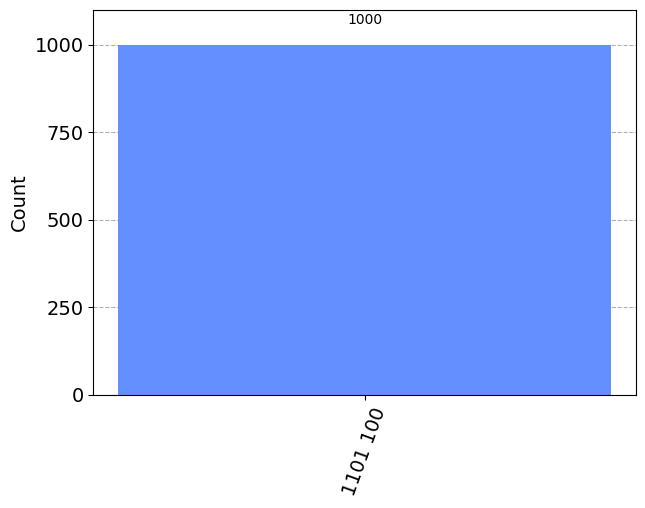

In [221]:
job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [225]:
# test QNMADD
def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])

def process_counts(counts):
    key = list(counts.keys())[0]
    key_parts = key.split(' ')
    first_num = int(key_parts[0], 2)
    second_num = int(key_parts[1], 2)
    return first_num, second_num

bit_length1 = 3
bit_length2 = 3
for first_num in range(2**(bit_length1-1)):
    for second_num in range(2**(bit_length2-1)):
        carry_register = QuantumRegister(1, name="c")
        first_register = QuantumRegister(bit_length1, name="a")
        second_register = QuantumRegister(bit_length2, name="b")
        first_register_results = ClassicalRegister(bit_length1, name="a_results")
        second_register_results = ClassicalRegister(bit_length2+1, name="b_results")

        test_circuit = QuantumCircuit(first_register, second_register,carry_register, first_register_results, second_register_results)

        loadNumber(test_circuit, first_register, first_num)
        loadNumber(test_circuit, second_register, second_num)

        test_circuit.append(build_QNMAdd(bit_length1, bit_length2), first_register[:] + second_register[:]+ carry_register[:])
        test_circuit.measure(first_register, first_register_results)
        test_circuit.measure(second_register[:]+ carry_register[:], second_register_results)
        job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
        results = job.result()
        counts = results.get_counts()
        print("num 1: {}, num 2: {}, result: {}, processed: {}".format(first_num, second_num, counts, process_counts(counts)))

num 1: 0, num 2: 0, result: {'0000 000': 1000}, processed: (0, 0)
num 1: 0, num 2: 1, result: {'0001 000': 1000}, processed: (1, 0)
num 1: 0, num 2: 2, result: {'0010 000': 1000}, processed: (2, 0)
num 1: 0, num 2: 3, result: {'0011 000': 1000}, processed: (3, 0)
num 1: 1, num 2: 0, result: {'0001 001': 1000}, processed: (1, 1)
num 1: 1, num 2: 1, result: {'0010 001': 1000}, processed: (2, 1)
num 1: 1, num 2: 2, result: {'0011 001': 1000}, processed: (3, 1)
num 1: 1, num 2: 3, result: {'0100 001': 1000}, processed: (4, 1)
num 1: 2, num 2: 0, result: {'0010 010': 1000}, processed: (2, 2)
num 1: 2, num 2: 1, result: {'0011 010': 1000}, processed: (3, 2)
num 1: 2, num 2: 2, result: {'0100 010': 1000}, processed: (4, 2)
num 1: 2, num 2: 3, result: {'0101 010': 1000}, processed: (5, 2)
num 1: 3, num 2: 0, result: {'0011 011': 1000}, processed: (3, 3)
num 1: 3, num 2: 1, result: {'0100 011': 1000}, processed: (4, 3)
num 1: 3, num 2: 2, result: {'0101 011': 1000}, processed: (5, 3)
num 1: 3, 

# Build QMAdd

In [204]:
def build_QMAdd(n, m):
    carry_register = QuantumRegister(1, name="c")
    first_register = QuantumRegister(n, name="a")
    second_register = QuantumRegister(m, name="b")
    circ = QuantumCircuit(carry_register, first_register, second_register, name="QMAdd")
    qft = qft_gate(n+1)
    inverse_qft = qft.inverse()
    circ.append(qft, [carry_register[0]]+ first_register[:])
    circ.barrier()
    circ.append(build_MAdd(m, n), carry_register[:] + first_register[:] + second_register[:])
    circ.barrier()
    circ.append(inverse_qft, [carry_register[0]]+ first_register[:])
    return circ

carry_register = QuantumRegister(1, name="c")
first_register = QuantumRegister(2, name="a")
second_register = QuantumRegister(2, name="b")

test_circuit = QuantumCircuit(carry_register, first_register, second_register)


test_circuit.x(first_register[1])
test_circuit.x(second_register[0])
test_circuit.barrier()

test_circuit.append(build_QMAdd(2, 2), carry_register[:] + first_register[:] + second_register[:])
test_circuit.measure_all()
test_circuit.decompose(reps=2).draw()

░ ┌───┐┌────┐     ┌────┐            ░             ┌────┐»
     c: ─────────────░─┤ H ├┤ R2 ├─────┤ R3 ├────────────░─────────────┤ R1 ├»
                     ░ └───┘└─┬──┘┌───┐└─┬──┘┌────┐      ░ ┌────┐      └─┬──┘»
   a_0: ─────────────░────────■───┤ H ├──┼───┤ R2 ├──────░─┤ R1 ├────────┼───»
        ┌──────────┐ ░            └───┘  │   └─┬──┘┌───┐ ░ └─┬──┘┌────┐  │   »
   a_1: ┤ U(π,0,π) ├─░───────────────────■─────■───┤ H ├─░───┼───┤ R1 ├──┼───»
        ├──────────┤ ░                             └───┘ ░   │   └─┬──┘  │   »
   b_0: ┤ U(π,0,π) ├─░───────────────────────────────────░───■─────┼─────■───»
        └──────────┘ ░                                   ░         │         »
   b_1: ─────────────░───────────────────────────────────░─────────■─────────»
                     ░                                   ░                   »
meas: 5/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ┌────┐ ░                               ┌──────────────────┐»
«     c: ──────┤ R2 ├─░───────────────────────────────┤ circuit-65236_dg ├»
«        ┌────┐└─┬──┘ ░      ┌──────────────────┐┌───┐└────────┬─────────┘»
«   a_0: ┤ R2 ├──┼────░──────┤ circuit-65245_dg ├┤ H ├─────────┼──────────»
«        └─┬──┘  │    ░ ┌───┐└────────┬─────────┘└───┘         │          »
«   a_1: ──┼─────┼────░─┤ H ├─────────■────────────────────────■──────────»
«          │     │    ░ └───┘                                             »
«   b_0: ──┼─────┼────░───────────────────────────────────────────────────»
«          │     │    ░                                                   »
«   b_1: ──■─────■────░───────────────────────────────────────────────────»
«                     ░                                                   »
«meas: 5/═════════════════════════════════════════════════════════════════»
«                                                                         »
«        ┌──────────────────┐┌───┐ ░ ┌─┐            
«     c: ┤ circuit-65227_dg ├┤ H ├─░─┤M├────────────
«        └────────┬─────────┘└───┘ ░ └╥┘┌─┐         
«   a_0: ─────────■────────────────░──╫─┤M├─────────
«                                  ░  ║ └╥┘┌─┐      
«   a_1: ──────────────────────────░──╫──╫─┤M├──────
«                                  ░  ║  ║ └╥┘┌─┐   
«   b_0: ──────────────────────────░──╫──╫──╫─┤M├───
«                                  ░  ║  ║  ║ └╥┘┌─┐
«   b_1: ──────────────────────────░──╫──╫──╫──╫─┤M├
«                                  ░  ║  ║  ║  ║ └╥┘
«meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
«                                     0  1  2  3  4

{'01110': 471, '01111': 529}


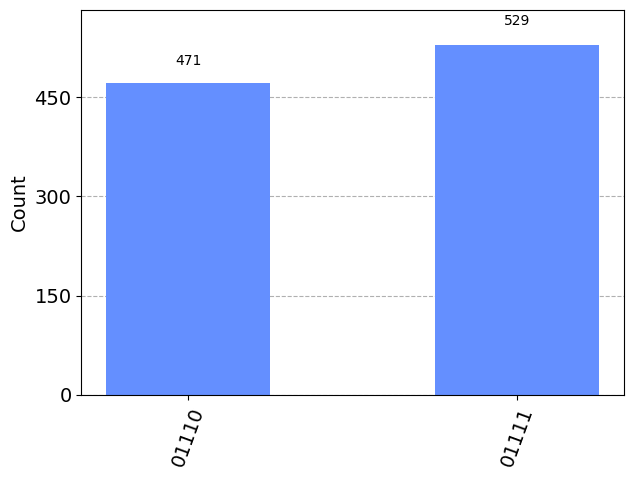

In [205]:
job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
results = job.result()
counts = results.get_counts()
print(counts)
# print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [206]:
# test QNMADD
def loadNumber(circ: QuantumCircuit, register: QuantumRegister, number: int):
    number_in_binary = '0'*(register.size - len(bin(number)[2:])) + bin(number)[2:]
    for i in range(len(number_in_binary)):
        if number_in_binary[::-1][i] == '1':
            circ.x(register[i])
            
bit_length = 3
for first_num in range(2**bit_length):
    for second_num in range(2**bit_length):
        carry_register = QuantumRegister(1, name="c")
        first_register = QuantumRegister(bit_length, name="a")
        second_register = QuantumRegister(bit_length, name="b")
        first_register_results = ClassicalRegister(bit_length, name="a_results")
        second_register_results = ClassicalRegister(bit_length+1, name="b_results")

        test_circuit = QuantumCircuit(first_register, second_register,carry_register, first_register_results, second_register_results)

        loadNumber(test_circuit, first_register, first_num)
        loadNumber(test_circuit, second_register, second_num)

        test_circuit.append(build_QMAdd(bit_length, bit_length), first_register[:] + second_register[:]+ carry_register[:])
        test_circuit.measure(first_register, first_register_results)
        test_circuit.measure(second_register[:]+ carry_register[:], second_register_results)
        job = execute(test_circuit, Aer.get_backend('aer_simulator'), shots=1000)
        results = job.result()
        counts = results.get_counts()
        print("num 1: {}, num 2: {}, result: {}".format(first_num, second_num, counts))

num 1: 0, num 2: 0, result: {'0000 000': 1000}
num 1: 0, num 2: 1, result: {'0001 000': 1000}
num 1: 0, num 2: 2, result: {'0010 011': 489, '0010 010': 511}
num 1: 0, num 2: 3, result: {'0011 011': 480, '0011 010': 520}
num 1: 0, num 2: 4, result: {'0100 101': 132, '0100 100': 868}
num 1: 0, num 2: 5, result: {'0101 101': 142, '0101 100': 858}
num 1: 0, num 2: 6, result: {'0110 110': 144, '0110 111': 856}
num 1: 0, num 2: 7, result: {'0111 110': 135, '0111 111': 865}
num 1: 1, num 2: 0, result: {'0000 001': 1000}
num 1: 1, num 2: 1, result: {'0001 001': 1000}
num 1: 1, num 2: 2, result: {'0010 011': 468, '0010 010': 532}
num 1: 1, num 2: 3, result: {'0011 011': 527, '0011 010': 473}
num 1: 1, num 2: 4, result: {'0100 100': 153, '0100 101': 847}
num 1: 1, num 2: 5, result: {'0101 100': 136, '0101 101': 864}
num 1: 1, num 2: 6, result: {'0110 111': 166, '0110 110': 834}
num 1: 1, num 2: 7, result: {'0111 110': 869, '0111 111': 131}
num 1: 2, num 2: 0, result: {'0000 010': 1000}
num 1: 2,